# Table of Contents
- [1. Introduction](#intro)
- [2. Imports](#setup)
- [3. Analysis](#analysis)
    - [3.1. Boxplot](#boxplot)
    - [3.2. Fitness across generations](#fitness)
    - [3.3. Summary of parameter search combinations](#summary)
    - [3.4. Comparing GA Performance Against a Random Baseline](#compare)

----

# 1. Introduction <a class="anchor" id="intro"></a>
In this notebook, we perform statistical analysis on the genetic-algorithm experiments whose results were generated in the Grid_search notebook.  
We will:

- Identify the best parameter combinations.
- Visualize fitness progression over generations for selected top performing experiments.  
- Export a summary table of the best experiments to Markdown and CSV for reporting.
----

----

# 2. Imports <a class="anchor" id="imports"></a>

----

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import ast  # For safely evaluating string literals
import re   # For regular expressions (to preprocess log strings)
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Make top-level folders importable (this notebook lives in Notebooks/)
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, project_root)

# Import your GA classes
from Genetic_algorithm.fitness    import ResourceFitness
from Genetic_algorithm.genome     import Genome
from Genetic_algorithm.solution_rd import SolutionRD

----

# 3. Analysis <a class="anchor" id="analysis"></a>

----

logs are a list of list with the following parameters:

* [n_fitness_calls, float(best_individual_of_generation), best_logistic_fitness, best_social_fitness]

In [2]:
grid_res_df = pd.read_csv('../Data/grid_search_results.csv')
grid_res_df.head()

,params,run_iteration,best_solution,logs
0,"{'gen_count': 100, 'selection_algorithm': <fun...",0,Fitness: 4.089441066296768,"[[35, 3.0925752311245436, np.float64(0.1925752..."
1,"{'gen_count': 100, 'selection_algorithm': <fun...",1,Fitness: 4.011586355252799,"[[16, 3.2206800505757838, np.float64(0.2206800..."
2,"{'gen_count': 100, 'selection_algorithm': <fun...",2,Fitness: 4.01907524952593,"[[30, 2.9884215725937135, np.float64(0.1884215..."
3,"{'gen_count': 100, 'selection_algorithm': <fun...",3,Fitness: 4.039931009161778,"[[16, 3.1210851794251786, np.float64(0.2210851..."
4,"{'gen_count': 100, 'selection_algorithm': <fun...",4,Fitness: 4.027377369408274,"[[28, 3.090238284598779, np.float64(0.29023828..."


----
### 3.1. Boxplot <a class="anchor" id="boxplot"></a>

We will generate a boxplot comparing the distribution of best fitness values for the top 8 hyperparameter combinations identified in the grid search. This will help us assess variability and central tendency of best solutions.


----


Found 64 unique experiment configurations in the 'params' column.
Identifying top experiments. Problem treated as maximization.

Selected top 8 experiments for plotting (requested 8):
  - Exp 40 (Avg Fitness: 4.3079, Params Maximization: True)
  - Exp 38 (Avg Fitness: 4.2800, Params Maximization: True)
  - Exp 46 (Avg Fitness: 4.2640, Params Maximization: True)
  - Exp 62 (Avg Fitness: 4.2551, Params Maximization: True)
  - Exp 14 (Avg Fitness: 4.2313, Params Maximization: True)
  - Exp 54 (Avg Fitness: 4.2230, Params Maximization: True)
  - Exp 39 (Avg Fitness: 4.2124, Params Maximization: True)
  - Exp 61 (Avg Fitness: 4.1689, Params Maximization: True)
Global Y-axis scale for top plots set from 3.75 to 4.76


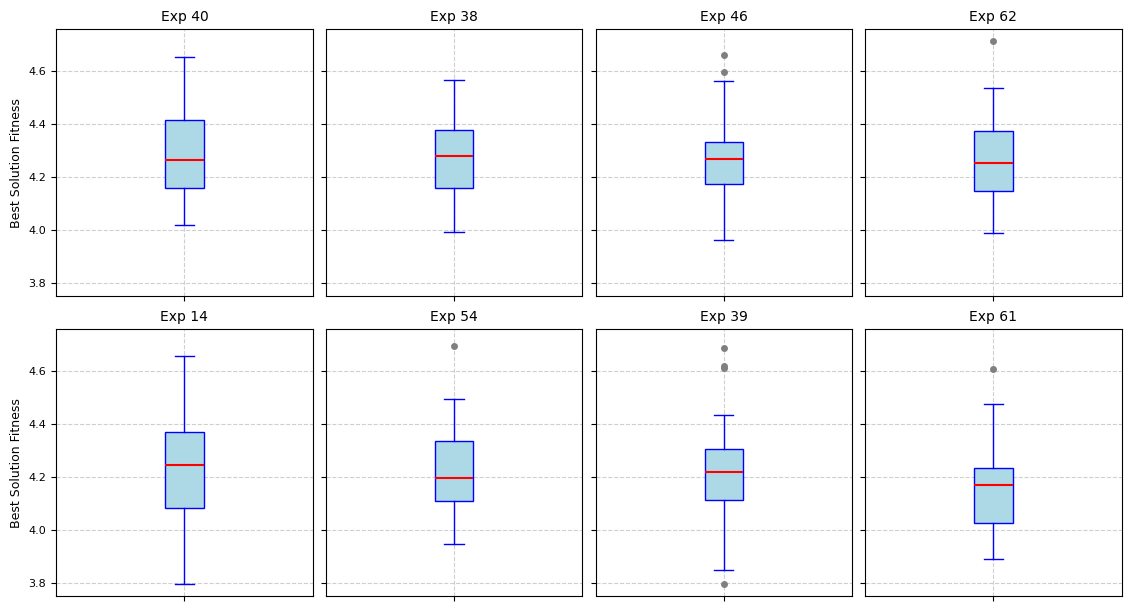

In [3]:
import os # This script is part of a larger file with directory ops

# --- Configuration ---
CSV_FILE_PATH = '../Data/grid_search_results.csv'  
# EXPECTED_UNIQUE_EXPERIMENTS is less relevant now as we filter, but can be kept for initial data load checks
EXPECTED_UNIQUE_EXPERIMENTS_IN_FILE = 64 

# --- Function to Parse Best Solution (unchanged) ---
def parse_best_solution(solution_str):
    try:
        return float(solution_str.split(': ')[1])
    except (IndexError, ValueError) as e:
        # print(f"Warning: Could not parse '{solution_str}'. Error: {e}. Returning NaN.") # Optional: reduce verbosity
        return np.nan

# --- Main Box Plotting Script ---
def create_experiment_boxplots(csv_path, expected_total_experiments, num_top_to_plot=12):
    # 1. Load the DataFrame
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"Error: The file '{csv_path}' was not found. Please check the path.")
        print("Using dummy data for demonstration purposes.")
        # Simplified dummy data generation for brevity in this example
        param_strings_demo = []
        for i in range(expected_total_experiments if expected_total_experiments > 0 else 20): # Ensure some dummy data
            maximization_flag = "True" if i % 2 == 0 else "False" # Mix maximization flags for testing
            param_strings_demo.append(f"{{'config': {i}, 'maximization': {maximization_flag}, 'setting': 'A'}}")

        data_demo = []
        for i, p_str in enumerate(param_strings_demo):
            for run_iter in range(10): # 10 runs per dummy experiment
                base_fitness = 5.0
                experiment_effect = (i % 10) * (1 if "'maximization': True" in p_str else -1) # Effect direction depends on goal
                fitness_val = base_fitness + experiment_effect + np.random.randn() * 1.5
                best_sol_str = f"Fitness: {fitness_val}"
                data_demo.append([p_str, run_iter, best_sol_str, "[[...]]"])
        df = pd.DataFrame(data_demo, columns=['params', 'run_iteration', 'best_solution', 'logs'])

    # 2. Parse the 'best_solution' column
    df['best_solution_value'] = df['best_solution'].apply(parse_best_solution)
    df.dropna(subset=['best_solution_value'], inplace=True)

    if df.empty:
        print("No data available after parsing solutions. Exiting.")
        return

    # 3. Identify unique experiments and map to simpler labels
    unique_param_strings = df['params'].unique()
    num_actual_unique_experiments = len(unique_param_strings)
    
    print(f"Found {num_actual_unique_experiments} unique experiment configurations in the 'params' column.")
    if num_actual_unique_experiments == 0:
        print("No unique experiment configurations found. Exiting.")
        return

    param_to_id = {param_str: f"Exp {i+1}" for i, param_str in enumerate(sorted(list(unique_param_strings)))}
    df['experiment_id'] = df['params'].map(param_to_id)

    # 4. Group data for ALL experiments initially
    all_experiments_data_temp = []
    all_experiments_labels_temp = []
    # Get sorted unique experiment IDs (e.g., "Exp 1", "Exp 2", ...)
    sorted_exp_ids = sorted(param_to_id.values(), key=lambda x: int(x.split(' ')[1]))

    for exp_id in sorted_exp_ids:
        solutions = df[df['experiment_id'] == exp_id]['best_solution_value'].tolist()
        if solutions:
            all_experiments_data_temp.append(solutions)
            all_experiments_labels_temp.append(exp_id)
        else:
            print(f"Warning: No solution data for {exp_id} after processing.")
            
    if not all_experiments_data_temp:
        print("No data available for any experiments after initial grouping. Exiting.")
        return

    # ------------------------------------------------------------------------------------
    # NEW SECTION: Filter for Top N experiments based on average performance
    # ------------------------------------------------------------------------------------
    experiment_performance = []
    is_maximization = True  # Default assumption
    maximization_flag_found_in_data = False

    # Attempt to determine maximization/minimization from a relevant params string
    # Create a reverse map from exp_id to param_string for lookup
    id_to_param_str_map = {v: k for k, v in param_to_id.items()}

    if all_experiments_labels_temp: # If there are any experiments with data
        first_exp_id_with_data = all_experiments_labels_temp[0]
        param_string_for_flag_check = id_to_param_str_map.get(first_exp_id_with_data)
        if param_string_for_flag_check:
            max_match = re.search(r"'maximization':\s*(True|False)", param_string_for_flag_check)
            if max_match:
                is_maximization = (max_match.group(1) == 'True')
                maximization_flag_found_in_data = True
        
    if not maximization_flag_found_in_data:
        print("Warning: 'maximization' flag not reliably found in params strings. Assuming maximization (higher average is better).")
    
    print(f"Identifying top experiments. Problem treated as {'maximization' if is_maximization else 'minimization'}.")

    for i, solutions_list in enumerate(all_experiments_data_temp):
        mean_fitness = np.mean(solutions_list)
        experiment_performance.append({
            'id': all_experiments_labels_temp[i],
            'mean_fitness': mean_fitness,
            'solutions': solutions_list,
            'param_string': id_to_param_str_map.get(all_experiments_labels_temp[i]) # Store for reference
        })
    
    # Sort experiments by performance (mean_fitness)
    experiment_performance.sort(key=lambda x: x['mean_fitness'], reverse=is_maximization)
    
    # Select top N experiments
    top_experiments_data_list = experiment_performance[:num_top_to_plot]

    if not top_experiments_data_list:
        print(f"No experiments available after trying to select top {num_top_to_plot}. Exiting.")
        return

    # Update data_for_plotting and plot_labels to contain only the top experiments
    data_for_plotting = [exp['solutions'] for exp in top_experiments_data_list]
    plot_labels = [exp['id'] for exp in top_experiments_data_list]
    
    num_plots_to_show = len(data_for_plotting)
    print(f"\nSelected top {num_plots_to_show} experiments for plotting (requested {num_top_to_plot}):")
    for exp_data in top_experiments_data_list:
        # Check if this experiment's specific 'maximization' flag matches the global one for clarity
        exp_specific_max_flag_str = "N/A"
        if exp_data['param_string']:
             exp_max_match = re.search(r"'maximization':\s*(True|False)", exp_data['param_string'])
             if exp_max_match : exp_specific_max_flag_str = exp_max_match.group(1)

        print(f"  - {exp_data['id']} (Avg Fitness: {exp_data['mean_fitness']:.4f}, Params Maximization: {exp_specific_max_flag_str})")
    # ------------------------------------------------------------------------------------
    # END NEW SECTION
    # ------------------------------------------------------------------------------------

    # 5. Determine Global Y-axis Limits (based on the filtered data_for_plotting)
    global_ymin, global_ymax = None, None
    all_solution_values_for_top_plots = []
    for solutions_list in data_for_plotting:
        all_solution_values_for_top_plots.extend(solutions_list)

    if not all_solution_values_for_top_plots:
        print("Warning: No numerical solution data for selected top plots. Plots will autoscale.")
    else:
        global_min_val = min(all_solution_values_for_top_plots)
        global_max_val = max(all_solution_values_for_top_plots)
        if global_min_val == global_max_val:
            global_ymin = global_min_val - 1
            global_ymax = global_max_val + 1
        else:
            padding = (global_max_val - global_min_val) * 0.05
            global_ymin = global_min_val - padding
            global_ymax = global_max_val + padding
        print(f"Global Y-axis scale for top plots set from {global_ymin:.2f} to {global_ymax:.2f}")

    # 6. Create Box Plots for the selected top experiments
    # Determine grid size for subplots (customized for up to 12 plots)
    if num_plots_to_show <= 0:
        print("No data to plot after filtering for top experiments.")
        return
    elif num_plots_to_show == 1: nrows, ncols = 1, 1
    elif num_plots_to_show == 2: nrows, ncols = 1, 2
    elif num_plots_to_show <= 4: nrows, ncols = 2, 2
    elif num_plots_to_show <= 6: nrows, ncols = 2, 3
    elif num_plots_to_show <= 8: nrows, ncols = 2, 4 # Max 8 plots in 2 rows
    elif num_plots_to_show <= 9: nrows, ncols = 3, 3
    elif num_plots_to_show <= 12: nrows, ncols = 3, 4 # Max 12 plots in 3 rows
    else: # Fallback if more than 12 are somehow plotted (e.g. num_top_to_plot changed)
        ncols = 4
        nrows = int(np.ceil(num_plots_to_show / ncols))
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 2.8, nrows * 3), constrained_layout=True)
    
    if num_plots_to_show == 1: axes_flat = [axes]
    else: axes_flat = axes.flatten()

    for i in range(num_plots_to_show):
        ax = axes_flat[i]
        ax.boxplot(data_for_plotting[i], patch_artist=True,
                   boxprops=dict(facecolor='lightblue', color='blue'),
                   medianprops=dict(color='red', linewidth=1.5),
                   whiskerprops=dict(color='blue'), capprops=dict(color='blue'),
                   flierprops=dict(markerfacecolor='grey', marker='o', markersize=5, linestyle='none', markeredgecolor='none'))
        ax.set_title(plot_labels[i], fontsize=10)
        ax.set_xticklabels([''])
        if global_ymin is not None and global_ymax is not None:
            ax.set_ylim(global_ymin, global_ymax)
        if i % ncols == 0: # Y-label only for first column plots
            ax.set_ylabel('Best Solution Fitness', fontsize=9)
        else:
            ax.set_yticklabels([])
        ax.tick_params(axis='y', labelsize=8)
        ax.grid(True, linestyle='--', alpha=0.6)

    for j in range(num_plots_to_show, nrows * ncols): # Hide unused subplots
        if j < len(axes_flat): fig.delaxes(axes_flat[j])

    # fig.suptitle(f'Box Plots of the Top {num_plots_to_show} Experiments by Average Fitness', fontsize=16)
    plt.show()

    return top_experiments_data_list

# Call the function, specifying how many top experiments to plot (e.g., 12)
top_experiments_data_list = create_experiment_boxplots(CSV_FILE_PATH, 
                            expected_total_experiments=EXPECTED_UNIQUE_EXPERIMENTS_IN_FILE, 
                            num_top_to_plot = 8)


Our best runs are not statistically significent different from each other.

----

### 3.2. Fitness across generations <a class="anchor" id="fitness"></a>
Now, we will plot the evolution of fitness (mean and median) over generations for the selected top experiments.  
This time-series view reveals convergence behavior and algorithmic stability for each parameter configuration.

----


In [4]:
# --- Configuration (ensure it's set if running standalone) ---
CSV_FILE_PATH = '../Data/grid_search_results.csv'  # <--- IMPORTANT: Change this to your CSV file path

def preprocess_log_string(log_str: str) -> str:
    """
    Prepares the log string for ast.literal_eval by handling np.float64() and similar.
    Example: "np.float64(0.123)" becomes "0.123"
    """
    if not isinstance(log_str, str):
        return "" 
    processed_str = re.sub(r'np\.float64\(([^)]+)\)', r'\1', log_str)
    return processed_str

def parse_fitness_trajectory_from_log(log_entry_str: str) -> list:
    """
    Parses a preprocessed log string for a single run and extracts 
    the 'best_individual_of_generation' fitness trajectory.
    """
    if not isinstance(log_entry_str, str) or not log_entry_str.strip().startswith('['):
        return [] 

    try:
        generations_data = ast.literal_eval(log_entry_str)
        
        if not isinstance(generations_data, list) or \
           not all(isinstance(gen_info, list) and len(gen_info) >= 2 for gen_info in generations_data):
            print(f"Warning: Unexpected structure in parsed log data. Skipping. Data: {str(generations_data)[:150]}")
            return []
            
        fitness_trajectory = [gen_info[1] for gen_info in generations_data]
        return fitness_trajectory
    except (SyntaxError, ValueError, TypeError) as e:
        print(f"Warning: Could not parse log string entry: {e}. Entry: {str(log_entry_str)[:150]}")
        return []

def create_log_dataframes_by_experiment(main_df: pd.DataFrame) -> dict:
    """
    Processes the 'logs' column of the main DataFrame to create a dictionary
    of DataFrames, where each DataFrame holds generation-wise fitness values
    for all runs of a specific experiment.
    Columns are named by generation number (e.g., "0", "1", ...).
    """
    required_columns = ['params', 'run_iteration', 'logs']
    if not all(col in main_df.columns for col in required_columns):
        missing_cols = [col for col in required_columns if col not in main_df.columns]
        print(f"Error: DataFrame missing required columns: {', '.join(missing_cols)}.")
        return {}

    if 'experiment_id' not in main_df.columns:
        unique_param_strings = main_df['params'].unique()
        param_to_id = {param_str: f"Exp {i+1}" for i, param_str in enumerate(sorted(list(unique_param_strings)))}
        main_df['experiment_id'] = main_df['params'].map(param_to_id)

    experiments_log_dfs_dict = {}
    
    sorted_experiment_ids = sorted(main_df['experiment_id'].unique(), 
                                   key=lambda x: int(x.split('Exp ')[1]))

    for exp_id in sorted_experiment_ids:
        print(f"Processing logs for {exp_id}...")
        experiment_runs_df = main_df[main_df['experiment_id'] == exp_id].copy()
        experiment_runs_df.sort_values('run_iteration', inplace=True)
        
        run_fitness_trajectories = []
        run_indices_for_df = [] 

        for _, row in experiment_runs_df.iterrows():
            log_string_for_run = row['logs']
            run_iter_number = row['run_iteration']
            
            preprocessed_log_str = preprocess_log_string(log_string_for_run)
            fitness_trajectory = parse_fitness_trajectory_from_log(preprocessed_log_str)
            
            if fitness_trajectory: 
                run_fitness_trajectories.append(fitness_trajectory)
                run_indices_for_df.append(run_iter_number)
            else:
                print(f"Info: No valid fitness trajectory extracted for {exp_id}, Run {run_iter_number}.")
        
        if not run_fitness_trajectories:
            print(f"Warning: No valid log data found for any run in {exp_id}. This experiment will be skipped.")
            continue
            
        max_generations = 0
        if run_fitness_trajectories:
             max_generations = max(len(traj) for traj in run_fitness_trajectories) if run_fitness_trajectories else 0
        
        # --- MODIFIED LINE FOR COLUMN NAMING ---
        generation_column_names = [str(i) for i in range(max_generations)]
        # --- END OF MODIFIED LINE ---
        
        padded_trajectories_for_df = []
        for traj in run_fitness_trajectories:
            padding_needed = max_generations - len(traj)
            padded_traj = traj + ([np.nan] * padding_needed)
            padded_trajectories_for_df.append(padded_traj)
            
        if padded_trajectories_for_df:
            exp_log_df = pd.DataFrame(
                padded_trajectories_for_df, 
                index=pd.Index(run_indices_for_df, name="Run Iteration"), 
                columns=generation_column_names
            )
            experiments_log_dfs_dict[exp_id] = exp_log_df
        else:
            print(f"Info: No data to create DataFrame for {exp_id} after processing trajectories.")
            
    print("\nFinished processing all experiment logs.")
    return experiments_log_dfs_dict

# --- Main execution block (example of how to use) ---
if __name__ == '__main__':
    main_application_df = None
    try:
        main_application_df = pd.read_csv(CSV_FILE_PATH)
    except FileNotFoundError:
        print(f"Error: The data file '{CSV_FILE_PATH}' was not found.")
        print("Using dummy data for demonstration purposes to show log parsing.")
        
        dummy_data_rows = []
        num_dummy_experiments = 2
        runs_per_experiment = 3 
        generations_per_run = 5

        for i in range(num_dummy_experiments):
            param_str = f"{{'config': {i+1}, 'detail': 'dummy_exp_{i+1}'}}"
            for r in range(runs_per_experiment):
                log_list_for_run = []
                for g in range(generations_per_run):
                    fitness_calls = (g + 1) * 10 + r
                    best_fitness = 10.0 + i*2 + r*0.5 + g*0.1 + np.random.rand()*0.1
                    logistic_fitness = best_fitness * 0.9
                    social_fitness = best_fitness * 0.8
                    log_list_for_run.append([fitness_calls, best_fitness, logistic_fitness, social_fitness])
                
                log_string_repr = str(log_list_for_run) 
                
                dummy_data_rows.append({
                    'params': param_str,
                    'run_iteration': r,
                    'best_solution': f"Fitness: {15.0 + i*2 + r*0.5}", 
                    'logs': log_string_repr
                })
        main_application_df = pd.DataFrame(dummy_data_rows)
        print("Dummy DataFrame created.")

    if main_application_df is not None and not main_application_df.empty:
        experiment_logs_data_dictionary = create_log_dataframes_by_experiment(main_application_df.copy())
        
        if experiment_logs_data_dictionary:
            print(f"\nSuccessfully processed logs for {len(experiment_logs_data_dictionary)} experiment(s).")
            # for exp_id, log_df in experiment_logs_data_dictionary.items():
            #     print(f"\n--- Log Data for {exp_id} ---")
            #     print(f"Shape: {log_df.shape} (Runs x Generations)")
            #     print("Columns:", log_df.columns.tolist()) # To verify new column names
            #     print(log_df.head()) 
        else:
            print("No log data was processed into DataFrames.")
            
    else:
        print("Could not proceed with log processing as the main DataFrame is empty or was not loaded.")

Processing logs for Exp 1...
Processing logs for Exp 2...
Processing logs for Exp 3...
Processing logs for Exp 4...
Processing logs for Exp 5...
Processing logs for Exp 6...
Processing logs for Exp 7...
Processing logs for Exp 8...
Processing logs for Exp 9...
Processing logs for Exp 10...
Processing logs for Exp 11...
Processing logs for Exp 12...
Processing logs for Exp 13...
Processing logs for Exp 14...
Processing logs for Exp 15...
Processing logs for Exp 16...
Processing logs for Exp 17...
Processing logs for Exp 18...
Processing logs for Exp 19...
Processing logs for Exp 20...
Processing logs for Exp 21...
Processing logs for Exp 22...
Processing logs for Exp 23...
Processing logs for Exp 24...
Processing logs for Exp 25...
Processing logs for Exp 26...
Processing logs for Exp 27...
Processing logs for Exp 28...
Processing logs for Exp 29...
Processing logs for Exp 30...
Processing logs for Exp 31...
Processing logs for Exp 32...
Processing logs for Exp 33...
Processing logs for

In [5]:
experiment_logs_data_dictionary['Exp 1']

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Run Iteration,,,,,,,,,,,,,,,,,,,,,
0,3.175132,3.410276,3.388337,3.315380,3.315380,3.315380,3.315380,3.315380,3.315380,3.318054,...,3.553190,3.553190,3.609701,3.553190,3.553190,3.553190,3.553190,3.553190,3.553190,3.553190
1,2.975387,2.914122,2.856777,2.895319,3.144808,3.144808,3.144808,3.144808,3.195251,3.244844,...,3.637030,3.637030,3.637030,3.637030,3.637030,3.637030,3.637030,3.637030,3.637030,3.637030
2,3.431879,3.383340,3.439216,3.383340,3.396916,3.396916,3.169430,3.169430,3.173725,3.373725,...,3.909805,3.909805,3.913688,4.008199,4.008199,4.008199,4.008199,4.008199,4.008199,4.008199
3,3.237230,3.035047,3.179601,3.009571,2.981468,3.252887,3.147032,3.147032,3.147032,3.128486,...,3.897511,3.997511,3.997511,3.997511,3.997511,4.034590,3.997511,4.034590,3.997511,3.997511
4,3.460627,3.744276,3.744276,3.744276,3.744276,3.744276,3.744276,3.744276,3.744276,3.744276,...,4.072859,4.072859,4.072859,4.072859,4.072859,4.072859,4.363067,4.363067,4.363067,4.363067
5,3.233162,3.233162,3.233162,3.101481,3.215959,3.212102,3.212102,3.212102,3.291286,3.212102,...,3.923104,3.923104,3.923104,3.923104,4.009155,4.009155,4.025009,4.025009,4.025009,4.002888
6,2.659703,2.992049,2.991199,2.992049,2.992049,3.215966,3.188675,3.323421,3.199455,3.389055,...,3.553266,3.451603,3.451603,3.536002,3.443958,3.443958,3.443958,3.456425,3.639522,3.643676
7,2.995342,2.995342,2.995342,2.995342,2.995342,2.813282,2.814804,2.814804,2.880649,2.635903,...,3.399432,3.399432,3.399432,3.399432,3.399432,3.399432,3.399432,3.399432,3.506288,3.506288
8,2.996549,2.996549,2.997748,2.997748,3.000071,3.079648,3.101169,3.106339,3.106339,3.106339,...,3.731053,3.731053,3.731053,3.731053,3.824470,3.831053,3.824470,3.824470,3.842589,3.842589


In [6]:
def plot_fitness_over_gen(fitness_dfs: dict[str, pd.DataFrame]):
    """
    Plots mean and median fitness over generations for different configurations.
    Adjusts x-axis ticks to show approximately every 10th generation number,
    ensuring the first and last generations are displayed.
    """
    if not fitness_dfs:
        print("No data provided to plot_fitness_over_gen.")
        return

    # Use constrained_layout for better automatic spacing if available (Matplotlib 3.x+)
    # It generally handles legends and titles better than manual adjustments.
    try:
        fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True, constrained_layout=True)
    except TypeError: # Fallback for older Matplotlib versions
        fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
        print("Warning: 'constrained_layout' not available. Plot layout may need manual adjustments.")

    custom_legend_handles = []
    custom_legend_labels = []
    
    master_generation_labels = []
    # Determine the master list of generation labels from the first DataFrame's columns
    # This assumes all DataFrames in fitness_dfs have columns named "0", "1", "2", ... representing generations.
    if fitness_dfs:
        try:
            first_df_key = next(iter(fitness_dfs))
            master_generation_labels = fitness_dfs[first_df_key].columns.tolist()
            # Basic validation that labels look like numbers
            if not all(label.isdigit() for label in master_generation_labels):
                print("Warning: DataFrame column names (generations) do not all appear to be numeric strings."
                      " X-tick adjustment might behave unexpectedly.")
        except StopIteration: # Should be caught by the initial `if not fitness_dfs`
            pass 
        except Exception as e:
            print(f"Error determining master generation labels: {e}. Using empty list.")
            master_generation_labels = []


    for config_name, df in fitness_dfs.items():
        if df.empty:
            print(f"Warning: DataFrame for '{config_name}' is empty. Skipping.")
            continue
        
        # Use the DataFrame's actual columns for plotting its data,
        # as these represent the generations for that specific df.
        current_generation_labels = df.columns.tolist() 
        
        mean_fitness = df.mean(axis=0)
        median_fitness = df.median(axis=0)
        
        # Plotting with current_generation_labels for x-axis
        line_mean, = axes[0].plot(current_generation_labels, mean_fitness.values, label=config_name)
        axes[1].plot(current_generation_labels, median_fitness.values, label=config_name)

        # For the custom shared legend, add only one entry per config_name
        if config_name not in custom_legend_labels:
            custom_legend_handles.append(line_mean)
            custom_legend_labels.append(config_name)

    axes[0].set_title("Mean Fitness Across Generations")
    axes[1].set_title("Median Fitness Across Generations")

    # --- X-axis Tick Adjustment ---
    # This will be applied based on master_generation_labels, assuming all plots
    # share a common understanding of generation sequence length.
    num_master_generations = len(master_generation_labels)
    tick_indices_to_show = [] # These are indices into the master_generation_labels list
    tick_labels_to_show = []  # The actual string labels like "0", "10", etc.

    if num_master_generations > 0:
        tick_step = 10
        
        # Add the first tick (generation 0)
        tick_indices_to_show.append(0)
        
        # Add ticks at `tick_step` intervals
        for i in range(tick_step, num_master_generations, tick_step):
            tick_indices_to_show.append(i)
            
        # Ensure the last generation tick is included if it's not already there
        # and if it provides useful information (e.g., not too close to the previous tick)
        last_gen_index = num_master_generations - 1
        if last_gen_index > 0 : # Only consider if there's more than one generation
            if last_gen_index not in tick_indices_to_show:
                # Condition to add: if no other ticks yet (besides 0), or if last planned tick is far enough,
                # or if there are very few ticks planned so far.
                is_last_tick_needed = True
                if len(tick_indices_to_show) > 1: # if we have more than just the '0' tick
                    if (last_gen_index - tick_indices_to_show[-1]) < (tick_step / 2) and len(tick_indices_to_show) > 2:
                         is_last_tick_needed = False # Too close to the previous one, and we have enough ticks

                if is_last_tick_needed:
                    tick_indices_to_show.append(last_gen_index)
        
        # Remove duplicates (if any, e.g. last_gen_index was a multiple of step) and sort
        tick_indices_to_show = sorted(list(set(tick_indices_to_show)))
        
        # Get the actual string labels for these tick indices
        tick_labels_to_show = [master_generation_labels[i] for i in tick_indices_to_show if i < num_master_generations]
    # --- End X-axis Tick Adjustment ---

    for ax_idx, ax in enumerate(axes):
        ax.set_xlabel("Generation")
        # Set Y label only for the first plot due to sharey=True
        ax.set_ylabel("Fitness" if ax_idx == 0 else "")
        ax.grid(True)
        
        if tick_indices_to_show: # Only set custom ticks if they were calculated
            # When plotting categorical data (strings on x-axis), Matplotlib uses positions 0, 1, 2...
            # So, tick_indices_to_show (which are 0, 10, 20... or similar) are the correct positions.
            ax.set_xticks(tick_indices_to_show)
            ax.set_xticklabels(tick_labels_to_show)
            # Optional: Rotate labels if they are still dense or long
            # ax.tick_params(axis='x', rotation=30, ha='right')
        elif num_master_generations > 0 : # Fallback: if no specific ticks, at least show first and last
            ax.set_xticks([0, num_master_generations - 1])
            ax.set_xticklabels([master_generation_labels[0], master_generation_labels[-1]])


    # Shared legend below the plots
    if custom_legend_handles:
        num_legend_cols = min(len(custom_legend_labels), 4) # Sensible number of columns
        legend = fig.legend(
            custom_legend_handles,
            custom_legend_labels,
            loc='lower center',
            # bbox_to_anchor positions the legend. (0.5, 0) is figure bottom center.
            # (0.5, -0.05) or similar pushes it slightly below.
            # constrained_layout often handles this. If not, adjust bbox_to_anchor and fig.subplots_adjust.
            bbox_to_anchor=(0.5, 0.01), # Try to place it just above the bottom edge if using constrained_layout
            ncol=num_legend_cols,
            frameon=True,
            borderpad=0.8
        )
        # If not using constrained_layout effectively, manual adjustment might be needed:
        if not fig.get_constrained_layout():
            num_legend_rows = (len(custom_legend_labels) - 1) // num_legend_cols + 1
            # Heuristic for bottom margin based on legend rows
            bottom_margin = 0.08 + num_legend_rows * 0.06 
            fig.subplots_adjust(bottom=min(bottom_margin, 0.35)) # Cap margin

    # If not using constrained_layout, tight_layout might be useful.
    # However, tight_layout and fig.legend can sometimes interfere.
    if not fig.get_constrained_layout():
        try:
            # rect can provide padding for elements like suptitle or external legends.
            plt.tight_layout(rect=[0, 0, 1, 0.95]) 
        except Exception as e:
            print(f"Note: tight_layout failed, possibly due to legend placement: {e}")
            # Fallback or further manual plt.subplots_adjust might be needed here.

    plt.show()

In [7]:
# get the top experiments data list from the previous function
top_experiments_data_list_names = [experiment['id'] for experiment in top_experiments_data_list]
top_experiments_data_list_names

['Exp 40',
 'Exp 38',
 'Exp 46',
 'Exp 62',
 'Exp 14',
 'Exp 54',
 'Exp 39',
 'Exp 61']

In [8]:

# extract all dataframes from the dictionary whose keys are in the top_experiments_data_list_names
experiment_logs_data_dictionary = {k: v for k, v in experiment_logs_data_dictionary.items() if k in top_experiments_data_list_names}


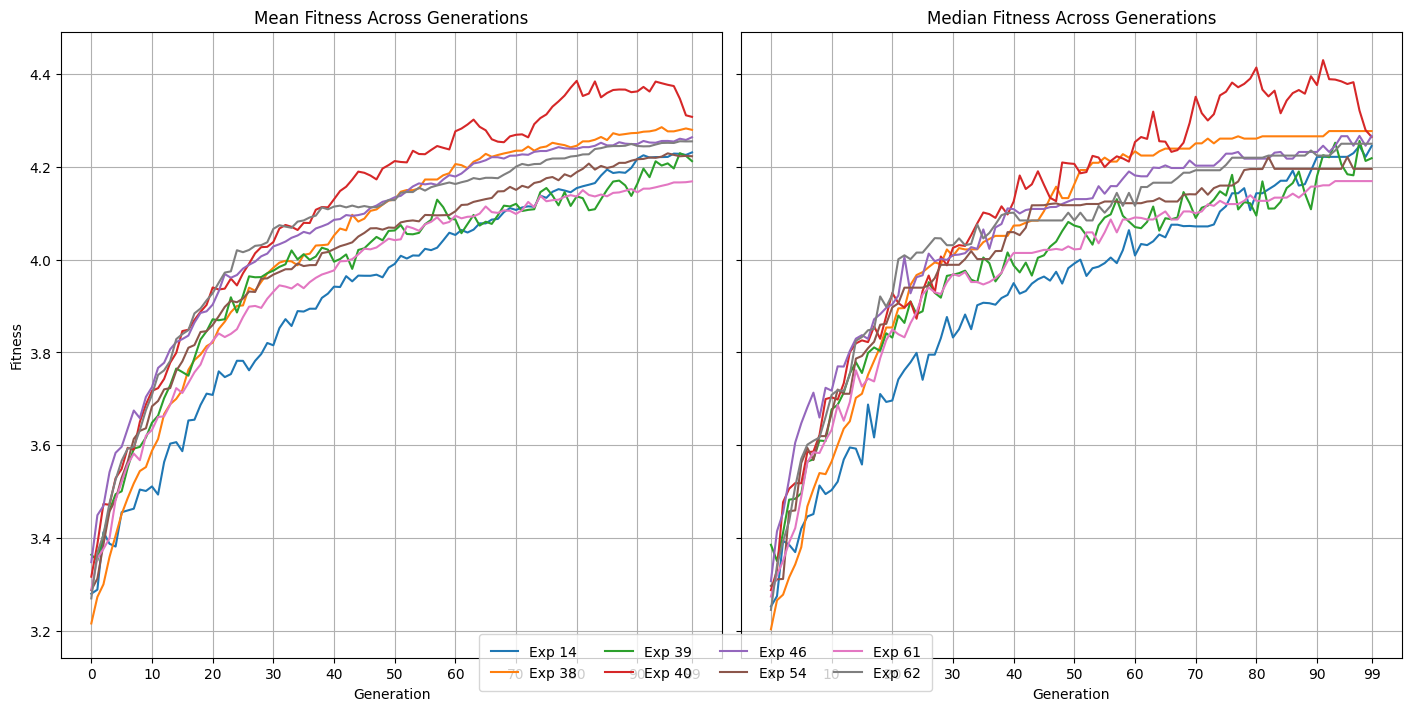

In [9]:
plot_fitness_over_gen(experiment_logs_data_dictionary)

----
### 3.3. Summary of parameter search combinations <a class="anchor" id="summary"></a>

Display the summary table of top experiments—including parameters and final fitness.
1) Table with all the parameter configurations tested.
2) Table with the top parameter combinations.

----

In [10]:
import pandas as pd
import matplotlib.pyplot as plt # Kept for context if running with previous script parts
import numpy as np
import re # For regular expression parsing


EXPECTED_UNIQUE_EXPERIMENTS = 64 # Used for context, not strictly for table generation if number differs

# --- Parameter Extraction Functions ---
def extract_function_name(text_repr):
    """Extracts function name from strings like '<function name at 0x...>'."""
    if not isinstance(text_repr, str): # Ensure input is a string
        return str(text_repr) 
    match = re.search(r"<function (\w+) at 0x[0-9a-fA-F]+>", text_repr)
    if match:
        return match.group(1)
    # Fallback for other potential representations or if it's already a name
    return text_repr 

def extract_algorithm_list(param_string, key_name):
    """
    Extracts a list of algorithm names from a string like "'key_name': [<func1>, <func2>]".
    """
    # Regex to find the list part, e.g., 'mutation_algorithms': [...]
    # It captures the content within the square brackets
    list_match = re.search(fr"'{key_name}':\s*\[(.*?)\]", param_string, re.DOTALL)
    if not list_match:
        return []
    
    list_content_str = list_match.group(1)
    
    # Find all function representations like <function name at 0x...> within the list content
    func_reprs = re.findall(r"<function \w+ at 0x[0-9a-fA-F]+>", list_content_str)
    
    return [extract_function_name(fr) for fr in func_reprs]

def extract_params_from_string(param_string):
    """
    Extracts specific parameters from a single 'params' string.
    """
    extracted_details = {}

    # Selection Algorithm
    # Example: 'selection_algorithm': <function tournament_selection at 0x...>
    sel_match = re.search(r"'selection_algorithm':\s*(<function \w+ at 0x[0-9a-fA-F]+>)", param_string)
    if sel_match:
        extracted_details['Selection Algorithm'] = extract_function_name(sel_match.group(1))
    else:
        extracted_details['Selection Algorithm'] = "N/A"

    # Mutation Algorithms
    mutation_algs = extract_algorithm_list(param_string, 'mutation_algorithms')
    extracted_details['Mutation Algorithms'] = ", ".join(mutation_algs) if mutation_algs else "N/A"
    
    # Crossover Algorithms
    crossover_algs = extract_algorithm_list(param_string, 'crossover_algorithms')
    extracted_details['Crossover Algorithms'] = ", ".join(crossover_algs) if crossover_algs else "N/A"

    # xo_prob (Crossover Probability)
    # Example: 'xo_prob': 0.2
    xo_match = re.search(r"'xo_prob':\s*([\d\.]+)", param_string)
    if xo_match:
        extracted_details['Crossover Prob (xo_prob)'] = float(xo_match.group(1))
    else:
        extracted_details['Crossover Prob (xo_prob)'] = np.nan # Use NaN for missing numeric data

    # mut_prob (Mutation Probability)
    # Example: 'mut_prob': 0.2
    mut_match = re.search(r"'mut_prob':\s*([\d\.]+)", param_string)
    if mut_match:
        extracted_details['Mutation Prob (mut_prob)'] = float(mut_match.group(1))
    else:
        extracted_details['Mutation Prob (mut_prob)'] = np.nan

    # Elitism
    # Example: 'elitism': True
    elitism_match = re.search(r"'elitism':\s*(True|False)", param_string)
    if elitism_match:
        extracted_details['Elitism'] = elitism_match.group(1) == 'True' # Convert string "True"/"False" to boolean
    else:
        # If 'elitism' key might be missing, decide on a default or "N/A"
        # Check if the key itself is present before assuming it should be True/False
        if "'elitism':" not in param_string:
             extracted_details['Elitism'] = "N/A (key missing)"
        else: # Key present but value not True/False (should not happen with valid data)
             extracted_details['Elitism'] = "N/A (parse error)"


    return extracted_details

# --- Function to Generate the Summary Table ---
def generate_parameter_summary_table(df):
    """
    Generates a summary table of experiment parameters from the DataFrame.
    Assumes df has a 'params' column with string representations of dictionaries.
    """
    if 'params' not in df.columns:
        print("Error: DataFrame does not contain a 'params' column.")
        return None

    unique_param_strings = df['params'].unique()
    
    # Create a mapping from param string to Experiment ID (e.g., "Exp 1") for consistency
    # Sorting unique_param_strings ensures "Exp 1" always refers to the same param config if script is rerun
    param_to_id = {param_str: f"Exp {i+1}" for i, param_str in enumerate(sorted(list(unique_param_strings)))}

    table_rows = []
    # Iterate in the order of Experiment IDs for a sorted table
    for param_str in sorted(param_to_id.keys(), key=lambda p: int(param_to_id[p].split(" ")[1])):
        exp_id = param_to_id[param_str]
        details = extract_params_from_string(param_str)
        
        row_data = {'Experiment ID': exp_id}
        row_data.update(details)
        table_rows.append(row_data)

    summary_df = pd.DataFrame(table_rows)
    
    # Define column order for the final table
    column_order = [
        'Experiment ID', 
        'Selection Algorithm', 
        'Mutation Algorithms', 
        'Crossover Algorithms', 
        'Crossover Prob (xo_prob)', 
        'Mutation Prob (mut_prob)', 
        'Elitism'
    ]
    # Ensure all requested columns are present, adding them with N/A if any were missed in extraction somehow
    for col in column_order:
        if col not in summary_df.columns:
            summary_df[col] = "N/A" # Or np.nan as appropriate
            
    summary_df = summary_df[column_order] # Reorder columns

    return summary_df

# --- Main execution block (example of how to use) ---

# 1. Load the main DataFrame (similar to the plotting script)
try:
    main_df = pd.read_csv(CSV_FILE_PATH)
except FileNotFoundError:
    print(f"Error: The file '{CSV_FILE_PATH}' was not found. Cannot generate parameter table.")
    print("Using a dummy 'params' string for demonstration of extraction logic:")
    # Example dummy params string that matches the expected structure for extraction
    dummy_param_example = ("{'gen_count': 100, 'selection_algorithm': <function tournament_selection at 0x10eaee0e0>, "
                            "'mutation_algorithms': [<function logistic_mutation at 0x10eaef5b0>, <function social_mutation at 0x10eaef640>], "
                            "'crossover_algorithms': [<function logistic_crossover_2 at 0x10eaefa30>, <function logistic_crossover_2 at 0x10eaefa30>], "
                            "'fitness_instance': <Genetic_algorithm.fitness.ResourceFitness object at 0x10eab38e0>, "
                            "'Genome_class': <class 'Genetic_algorithm.genome.Genome'>, 'maximization': True, "
                            "'xo_prob': 0.2, 'mut_prob': 0.2, 'social_mutation_prob': 0.5, 'social_crossover_prob': 0.5, "
                            "'population_size': 10, 'elitism': True, 'save_logs': True}")
    
    print("\n--- Dummy Param String Extraction Example ---")
    extracted_dummy_details = extract_params_from_string(dummy_param_example)
    for key, value in extracted_dummy_details.items():
        print(f"{key}: {value}")
    
    # Create a minimal DataFrame for demonstration if file is not found
    # This dummy_df will likely result in "N/A" for most fields in the summary table,
    # unless you make dummy_param_strings more complex like dummy_param_example.
    param_strings_demo = [
        f"{{'config': {i}, 'setting': 'A', 'xo_prob': 0.{i}, 'mut_prob': 0.1, 'elitism': {i%2==0}}}" # Simplified dummy
        for i in range(5) # Small number for demo
    ]
    # Add the complex dummy example to the list for one good row
    if EXPECTED_UNIQUE_EXPERIMENTS > 0 : # only if expected experiments are more than 0
            param_strings_demo.append(dummy_param_example)

    main_df = pd.DataFrame({'params': param_strings_demo})
    # Note: The dummy data above is very simple and may not contain all keys,
    # leading to "N/A" in the table. The `dummy_param_example` is more representative.
    print("\nAttempting to generate table with minimal dummy data (expect many N/A or errors if keys missing):")


if main_df is not None and not main_df.empty:
    summary_table = generate_parameter_summary_table(main_df)
    if summary_table is not None:
        print("\n--- Experiment Parameters Summary Table ---")
        # For a clean console output that's wide enough:
        with pd.option_context('display.max_rows', None, 
                                'display.max_columns', None, 
                                'display.width', 1000):
            print(summary_table)

        # For easy inclusion in a report, you might prefer Markdown:
        print("\n--- Table in Markdown Format ---")
        print(summary_table.to_markdown(index=False))
        
        # Or save to a CSV file:
        summary_table.to_csv('../Visualization/experiment_parameters_summary.csv', index=False)
        print("\nSummary table saved to 'experiment_parameters_summary.csv'")
else:
    print("Could not proceed with table generation as DataFrame is empty or not loaded.")


--- Experiment Parameters Summary Table ---
   Experiment ID   Selection Algorithm                   Mutation Algorithms                        Crossover Algorithms  Crossover Prob (xo_prob)  Mutation Prob (mut_prob)  Elitism
0          Exp 1        rank_selection    logistic_mutation, social_mutation              full_crossover, full_crossover                       0.2                       0.2    False
1          Exp 2        rank_selection    logistic_mutation, social_mutation              full_crossover, full_crossover                       0.2                       0.2     True
2          Exp 3        rank_selection    logistic_mutation, social_mutation              full_crossover, full_crossover                       0.2                       0.8    False
3          Exp 4        rank_selection    logistic_mutation, social_mutation              full_crossover, full_crossover                       0.2                       0.8     True
4          Exp 5        rank_selection    log

| Experiment ID   | Selection Algorithm   | Mutation Algorithms                  | Crossover Algorithms                       |   Crossover Prob (xo_prob) |   Mutation Prob (mut_prob) | Elitism   |
|:----------------|:----------------------|:-------------------------------------|:-------------------------------------------|---------------------------:|---------------------------:|:----------|
| Exp 1           | rank_selection        | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.2 |                        0.2 | False     |
| Exp 2           | rank_selection        | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.2 |                        0.2 | True      |
| Exp 3           | rank_selection        | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.2 |                        0.8 | False     |
| Exp 4           | rank_selection        | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.2 |                        0.8 | True      |
| Exp 5           | rank_selection        | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.8 |                        0.2 | False     |
| Exp 6           | rank_selection        | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.8 |                        0.2 | True      |
| Exp 7           | rank_selection        | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.8 |                        0.8 | False     |
| Exp 8           | rank_selection        | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.8 |                        0.8 | True      |
| Exp 9           | rank_selection        | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.2 |                        0.2 | False     |
| Exp 10          | rank_selection        | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.2 |                        0.2 | True      |
| Exp 11          | rank_selection        | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.2 |                        0.8 | False     |
| Exp 12          | rank_selection        | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.2 |                        0.8 | True      |
| Exp 13          | rank_selection        | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.2 | False     |
| Exp 14          | rank_selection        | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.2 | True      |
| Exp 15          | rank_selection        | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.8 | False     |
| Exp 16          | rank_selection        | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.8 | True      |
| Exp 17          | rank_selection        | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.2 |                        0.2 | False     |
| Exp 18          | rank_selection        | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.2 |                        0.2 | True      |
| Exp 19          | rank_selection        | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.2 |                        0.8 | False     |
| Exp 20          | rank_selection        | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.2 |                        0.8 | True      |
| Exp 21          | rank_selection        | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.8 |                        0.2 | False     |
| Exp 22          | rank_selection        | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.8 |                        0.2 | True      |
| Exp 23          | rank_selection        | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.8 |                        0.8 | False     |
| Exp 24          | rank_selection        | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.8 |                        0.8 | True      |
| Exp 25          | rank_selection        | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.2 |                        0.2 | False     |
| Exp 26          | rank_selection        | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.2 |                        0.2 | True      |
| Exp 27          | rank_selection        | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.2 |                        0.8 | False     |
| Exp 28          | rank_selection        | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.2 |                        0.8 | True      |
| Exp 29          | rank_selection        | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.2 | False     |
| Exp 30          | rank_selection        | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.2 | True      |
| Exp 31          | rank_selection        | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.8 | False     |
| Exp 32          | rank_selection        | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.8 | True      |
| Exp 33          | tournament_selection  | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.2 |                        0.2 | False     |
| Exp 34          | tournament_selection  | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.2 |                        0.2 | True      |
| Exp 35          | tournament_selection  | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.2 |                        0.8 | False     |
| Exp 36          | tournament_selection  | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.2 |                        0.8 | True      |
| Exp 37          | tournament_selection  | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.8 |                        0.2 | False     |
| Exp 38          | tournament_selection  | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.8 |                        0.2 | True      |
| Exp 39          | tournament_selection  | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.8 |                        0.8 | False     |
| Exp 40          | tournament_selection  | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.8 |                        0.8 | True      |
| Exp 41          | tournament_selection  | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.2 |                        0.2 | False     |
| Exp 42          | tournament_selection  | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.2 |                        0.2 | True      |
| Exp 43          | tournament_selection  | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.2 |                        0.8 | False     |
| Exp 44          | tournament_selection  | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.2 |                        0.8 | True      |
| Exp 45          | tournament_selection  | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.2 | False     |
| Exp 46          | tournament_selection  | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.2 | True      |
| Exp 47          | tournament_selection  | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.8 | False     |
| Exp 48          | tournament_selection  | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.8 | True      |
| Exp 49          | tournament_selection  | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.2 |                        0.2 | False     |
| Exp 50          | tournament_selection  | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.2 |                        0.2 | True      |
| Exp 51          | tournament_selection  | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.2 |                        0.8 | False     |
| Exp 52          | tournament_selection  | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.2 |                        0.8 | True      |
| Exp 53          | tournament_selection  | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.8 |                        0.2 | False     |
| Exp 54          | tournament_selection  | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.8 |                        0.2 | True      |
| Exp 55          | tournament_selection  | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.8 |                        0.8 | False     |
| Exp 56          | tournament_selection  | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.8 |                        0.8 | True      |
| Exp 57          | tournament_selection  | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.2 |                        0.2 | False     |
| Exp 58          | tournament_selection  | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.2 |                        0.2 | True      |
| Exp 59          | tournament_selection  | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.2 |                        0.8 | False     |
| Exp 60          | tournament_selection  | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.2 |                        0.8 | True      |
| Exp 61          | tournament_selection  | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.2 | False     |
| Exp 62          | tournament_selection  | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.2 | True      |
| Exp 63          | tournament_selection  | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.8 | False     |
| Exp 64          | tournament_selection  | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.8 | True      |

In [11]:
# Write the table as a markdown table called experiment_table into the folder Visualization


import pandas as pd
# matplotlib.pyplot is not directly used for table generation but might be in your full script
# import matplotlib.pyplot as plt 
import numpy as np
import re # For regular expression parsing
import os # For directory and path operations

# --- Configuration (ensure it's set) ---
EXPECTED_UNIQUE_EXPERIMENTS = 64 

# --- Parameter Extraction Functions (from previous response, unchanged) ---
def extract_function_name(text_repr):
    if not isinstance(text_repr, str):
        return str(text_repr) 
    match = re.search(r"<function (\w+) at 0x[0-9a-fA-F]+>", text_repr)
    if match:
        return match.group(1)
    return text_repr 

def extract_algorithm_list(param_string, key_name):
    list_match = re.search(fr"'{key_name}':\s*\[(.*?)\]", param_string, re.DOTALL)
    if not list_match:
        return []
    list_content_str = list_match.group(1)
    func_reprs = re.findall(r"<function \w+ at 0x[0-9a-fA-F]+>", list_content_str)
    return [extract_function_name(fr) for fr in func_reprs]

def extract_params_from_string(param_string):
    extracted_details = {}
    sel_match = re.search(r"'selection_algorithm':\s*(<function \w+ at 0x[0-9a-fA-F]+>)", param_string)
    if sel_match:
        extracted_details['Selection Algorithm'] = extract_function_name(sel_match.group(1))
    else:
        extracted_details['Selection Algorithm'] = "N/A"

    mutation_algs = extract_algorithm_list(param_string, 'mutation_algorithms')
    extracted_details['Mutation Algorithms'] = ", ".join(mutation_algs) if mutation_algs else "N/A"
    
    crossover_algs = extract_algorithm_list(param_string, 'crossover_algorithms')
    extracted_details['Crossover Algorithms'] = ", ".join(crossover_algs) if crossover_algs else "N/A"

    xo_match = re.search(r"'xo_prob':\s*([\d\.]+)", param_string)
    if xo_match:
        extracted_details['Crossover Prob (xo_prob)'] = float(xo_match.group(1))
    else:
        extracted_details['Crossover Prob (xo_prob)'] = np.nan

    mut_match = re.search(r"'mut_prob':\s*([\d\.]+)", param_string)
    if mut_match:
        extracted_details['Mutation Prob (mut_prob)'] = float(mut_match.group(1))
    else:
        extracted_details['Mutation Prob (mut_prob)'] = np.nan

    elitism_match = re.search(r"'elitism':\s*(True|False)", param_string)
    if elitism_match:
        extracted_details['Elitism'] = elitism_match.group(1) == 'True'
    else:
        if "'elitism':" not in param_string:
             extracted_details['Elitism'] = "N/A (key missing)"
        else:
             extracted_details['Elitism'] = "N/A (parse error)"
    return extracted_details

# --- Function to Generate the Summary Table (from previous response, unchanged) ---
def generate_parameter_summary_table(df):
    if 'params' not in df.columns:
        print("Error: DataFrame does not contain a 'params' column.")
        return None
    unique_param_strings = df['params'].unique()
    param_to_id = {param_str: f"Exp {i+1}" for i, param_str in enumerate(sorted(list(unique_param_strings)))}
    table_rows = []
    for param_str in sorted(param_to_id.keys(), key=lambda p: int(param_to_id[p].split(" ")[1])):
        exp_id = param_to_id[param_str]
        details = extract_params_from_string(param_str)
        row_data = {'Experiment ID': exp_id}
        row_data.update(details)
        table_rows.append(row_data)
    summary_df = pd.DataFrame(table_rows)
    column_order = [
        'Experiment ID', 'Selection Algorithm', 'Mutation Algorithms', 
        'Crossover Algorithms', 'Crossover Prob (xo_prob)', 
        'Mutation Prob (mut_prob)', 'Elitism'
    ]
    for col in column_order:
        if col not in summary_df.columns:
            summary_df[col] = "N/A"
    summary_df = summary_df[column_order]
    return summary_df

# --- Main execution block ---
if __name__ == '__main__':
    main_df = None
    try:
        main_df = pd.read_csv(CSV_FILE_PATH)
    except FileNotFoundError:
        print(f"Error: The data file '{CSV_FILE_PATH}' was not found.")
        print("Using a dummy 'params' string for demonstration of extraction logic if no file found:")
        dummy_param_example = ("{'gen_count': 100, 'selection_algorithm': <function tournament_selection at 0x10eaee0e0>, "
                               "'mutation_algorithms': [<function logistic_mutation at 0x10eaef5b0>, <function social_mutation at 0x10eaef640>], "
                               "'crossover_algorithms': [<function logistic_crossover_2 at 0x10eaefa30>, <function logistic_crossover_2 at 0x10eaefa30>], "
                               "'fitness_instance': <Genetic_algorithm.fitness.ResourceFitness object at 0x10eab38e0>, "
                               "'Genome_class': <class 'Genetic_algorithm.genome.Genome'>, 'maximization': True, "
                               "'xo_prob': 0.2, 'mut_prob': 0.2, 'social_mutation_prob': 0.5, 'social_crossover_prob': 0.5, "
                               "'population_size': 10, 'elitism': True, 'save_logs': True}")
        
        print("\n--- Dummy Param String Extraction Example ---")
        extracted_dummy_details = extract_params_from_string(dummy_param_example)
        for key, value in extracted_dummy_details.items():
            print(f"{key}: {value}")
        
        param_strings_demo = [dummy_param_example] # Use the detailed example for dummy data
        # Add more simplified dummy strings if needed for a larger dummy table
        for i in range(1, 3): # Add a couple more varied dummy examples
             param_strings_demo.append(
                 f"{{'config': {i}, 'selection_algorithm': <function sel_type_{i} at 0x...>, "
                 f"'mutation_algorithms': [<function mut_A at 0x...>, <function mut_B at 0x...>], "
                 f"'crossover_algorithms': [<function xo_X at 0x...>], "
                 f"'xo_prob': 0.{i+5}, 'mut_prob': 0.{i+1}, 'elitism': {i%2==0}}}"
             )
        main_df = pd.DataFrame({'params': param_strings_demo})
        print("\nAttempting to generate table with dummy data as primary CSV was not found.")

    if main_df is not None and not main_df.empty:
        summary_table = generate_parameter_summary_table(main_df)
        if summary_table is not None:
            # print("\n--- Experiment Parameters Summary Table (Console Output) ---")
            # with pd.option_context('display.max_rows', None, 
            #                        'display.max_columns', None, 
            #                        'display.width', 1000):
            #     print(summary_table)

            # --- Save table to Markdown file ---
            output_directory = "../Visualization"
            output_filename = "experiment_overview.md"
            # Ensure the output path is OS-agnostic
            output_filepath = os.path.join(output_directory, output_filename)

            try:
                # Create the directory if it doesn't exist
                os.makedirs(output_directory, exist_ok=True)
                print(f"\nDirectory '{output_directory}' ensured or already exists.")
                
                # Generate Markdown string from the DataFrame
                markdown_table_string = summary_table.to_markdown(index=False)
                
                # Write the Markdown string to the specified file
                with open(output_filepath, 'w', encoding='utf-8') as f:
                    f.write(markdown_table_string)
                print(f"Summary table successfully saved to Markdown file: '{output_filepath}'")
                
            except OSError as e:
                print(f"Error creating directory '{output_directory}': {e}")
            except IOError as e:
                print(f"Error writing Markdown file '{output_filepath}': {e}")
            except Exception as e:
                print(f"An unexpected error occurred during file saving: {e}")
            # --- End save table to Markdown file ---
    else:
        print("Could not proceed with table generation as DataFrame is empty or was not loaded.")


Directory '../Visualization' ensured or already exists.
Summary table successfully saved to Markdown file: '../Visualization/experiment_overview.md'


In [12]:
# write the table as a markdown table into visualization



| Experiment ID   | Selection Algorithm   | Mutation Algorithms                  | Crossover Algorithms                       |   Crossover Prob (xo_prob) |   Mutation Prob (mut_prob) | Elitism   |
|:----------------|:----------------------|:-------------------------------------|:-------------------------------------------|---------------------------:|---------------------------:|:----------|
| Exp 40          | tournament_selection  | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.8 |                        0.8 | True      |
| Exp 38          | tournament_selection  | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.8 |                        0.2 | True      |
| Exp 46          | tournament_selection  | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.2 | True      |
| Exp 62          | tournament_selection  | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.2 | True      |
| Exp 14          | rank_selection        | logistic_mutation, social_mutation   | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.2 | True      |
| Exp 54          | tournament_selection  | logistic_mutation_2, social_mutation | full_crossover, full_crossover             |                        0.8 |                        0.2 | True      |
| Exp 39          | tournament_selection  | logistic_mutation, social_mutation   | full_crossover, full_crossover             |                        0.8 |                        0.8 | False     |
| Exp 61          | tournament_selection  | logistic_mutation_2, social_mutation | logistic_crossover_2, logistic_crossover_2 |                        0.8 |                        0.2 | False     |

----
### 3.4. Comparing GA Performance Against a Random Baseline <a class="anchor" id="compare"></a>

In the following code cell we:

1. **Load our grid‐search results** (`grid_search_results.csv`) and parse out the numeric fitness scores for each hyperparameter setting.
2. **Rank the parameter combinations** by their mean fitness and select:
   - **Best** (highest mean)
   - **Middle** (median mean)
   - **Worst** (lowest mean)
3. **Reconstruct the GA’s fitness function** using our distance matrix (`distance_matrix_official.csv`) so that we can re‐generate and evaluate random solutions with exactly the same scoring logic.
4. **Simulate a “random baseline”**, drawing a single generation of 10 entirely random solutions for each run, to match the number of GA runs.
5. **Compute summary statistics** (mean, median, standard deviation) for each of the four sets of runs: Best GA, Middle GA, Worst GA, and Random.
6. **Visualize** the distributions side‐by‐side using a styled boxplot (light‐blue fills, red medians, dashed grid).
7. **Perform statistical tests** Mann–Whitney U to determine whether each GA tier significantly outperforms random.

This workflow allows us to see not only how our tuned GA compares to chance, but also how much of a gap exists between our best and worst hyperparameter choices—and whether any of those gaps are statistically meaningful.


----

Best hyperparameters:
{'gen_count': 100, 'selection_algorithm': <function tournament_selection at 0x10eaee0e0>, 'mutation_algorithms': [<function logistic_mutation at 0x10eaef5b0>, <function social_mutation at 0x10eaef640>], 'crossover_algorithms': [<function full_crossover at 0x10eaef7f0>, <function full_crossover at 0x10eaef7f0>], 'fitness_instance': <Genetic_algorithm.fitness.ResourceFitness object at 0x10eab38e0>, 'Genome_class': <class 'Genetic_algorithm.genome.Genome'>, 'maximization': True, 'xo_prob': 0.8, 'mut_prob': 0.8, 'social_mutation_prob': 0.5, 'social_crossover_prob': 0.5, 'population_size': 10, 'elitism': True, 'save_logs': True}
 GA → mean=4.3079, median=4.2647, std=0.1830

Middle hyperparameters:
{'gen_count': 100, 'selection_algorithm': <function tournament_selection at 0x10eaee0e0>, 'mutation_algorithms': [<function logistic_mutation_2 at 0x10eaef760>, <function social_mutation at 0x10eaef640>], 'crossover_algorithms': [<function full_crossover at 0x10eaef7f0>, <fun

/var/folders/1v/g732xzmj3fq2t8__lcdf8r_40000gn/T/ipykernel_3381/2945875239.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


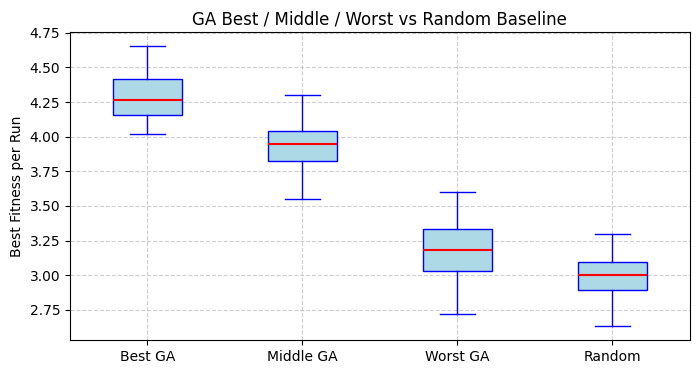

Best GA significantly outperforms Random (p = 1.510e-11)
Middle GA significantly outperforms Random (p = 1.510e-11)
Worst GA significantly outperforms Random (p = 6.181e-04)


In [13]:
# ——————————————————————————————————————————————
# GA Best vs GA Middle vs GA Worst vs Random Baseline Comparison
# ——————————————————————————————————————————————
# 3) Load grid-search results and parse fitness
csv_path = os.path.join(project_root, "Data", "grid_search_results.csv")
df = pd.read_csv(csv_path)

def parse_best_solution(sol_str):
    try:
        return float(re.search(r"([-+]?[0-9]*\.?[0-9]+)", sol_str).group(1))
    except:
        return np.nan

df["fitness"] = df["best_solution"].apply(parse_best_solution)
df.dropna(subset=["fitness"], inplace=True)

# 4) Identify best, middle, and worst hyperparameters by mean fitness
stats = df.groupby("params")["fitness"].agg(["mean","median","std"])
# sort by mean descending (maximization problem)
stats_sorted = stats.sort_values("mean", ascending=False)
param_list = stats_sorted.index.tolist()
best_params   = param_list[0]
middle_params = param_list[len(param_list)//2]
worst_params  = param_list[-1]

ga_best_scores   = df.loc[df["params"] == best_params,   "fitness"].values
ga_middle_scores = df.loc[df["params"] == middle_params, "fitness"].values
ga_worst_scores  = df.loc[df["params"] == worst_params,  "fitness"].values

print("Best hyperparameters:")
print(best_params)
print(f" GA → mean={stats_sorted.loc[best_params,'mean']:.4f}, "
      f"median={stats_sorted.loc[best_params,'median']:.4f}, "
      f"std={stats_sorted.loc[best_params,'std']:.4f}\n")

print("Middle hyperparameters:")
print(middle_params)
print(f" GA → mean={stats_sorted.loc[middle_params,'mean']:.4f}, "
      f"median={stats_sorted.loc[middle_params,'median']:.4f}, "
      f"std={stats_sorted.loc[middle_params,'std']:.4f}\n")

print("Worst hyperparameters:")
print(worst_params)
print(f" GA → mean={stats_sorted.loc[worst_params,'mean']:.4f}, "
      f"median={stats_sorted.loc[worst_params,'median']:.4f}, "
      f"std={stats_sorted.loc[worst_params,'std']:.4f}\n")

# 5) Build the same fitness object your GA used
dm_path          = os.path.join(project_root, "Data", "distance_matrix_official.csv")
dist_df          = pd.read_csv(dm_path, index_col=0)
fitness_instance = ResourceFitness(dist_df.to_numpy())

# 6) Simulate random-baseline (pop=10, same # of runs as the largest GA set)
pop_size   = 10
num_runs   = max(len(ga_best_scores), len(ga_middle_scores), len(ga_worst_scores))

random_scores = []
for _ in range(num_runs):
    pop = [SolutionRD(fitness_instance, Genome, [], []) for _ in range(pop_size)]
    random_scores.append(max(ind.fitness for ind in pop))

print("Random baseline:")
print(f" → mean={np.mean(random_scores):.4f}, "
      f"median={np.median(random_scores):.4f}, "
      f"std={np.std(random_scores):.4f}\n")

# 7) Styled boxplot for Best GA, Middle GA, Worst GA, and Random
plt.figure(figsize=(8,4))
plt.boxplot(
    [ga_best_scores, ga_middle_scores, ga_worst_scores, random_scores],
    labels=["Best GA", "Middle GA", "Worst GA", "Random"],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red', linewidth=1.5),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    flierprops=dict(markerfacecolor='grey', marker='o', markersize=5,
                    linestyle='none', markeredgecolor='none')
)
plt.ylabel("Best Fitness per Run")
plt.title("GA Best / Middle / Worst vs Random Baseline")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 8) Statistical tests and formatted printouts
def report_test(label, ga_scores, random_scores):
    u_stat, p_val = mannwhitneyu(ga_scores, random_scores, alternative="greater")
    if p_val < 0.05:
        print(f"{label} significantly outperforms Random (p = {p_val:.3e})")
    else:
        print(f"{label} does not significantly outperform Random (p = {p_val:.3e})")

report_test("Best GA",   ga_best_scores,   random_scores)
report_test("Middle GA", ga_middle_scores, random_scores)
report_test("Worst GA",  ga_worst_scores,  random_scores)